## En este primer hito queremos responder las siguientes preguntas:
- ¿Que cantidad de ítems únicos conforman mi target?

- ¿Cuántos ítems mira un usuario antes de realizar una compra?

- ¿Cuántas búsquedas realiza un usuario antes de realizar una compra?

- ¿Qué proporción de los ítems vistos corresponden a la categoría del ítem finalmente comprado?

- ¿Cuántas categorías recorre un usuario hasta comprar un item?

- ¿Cómo se relacionan los precios de los ítems vistos con el ítem comprado?

- ¿Cuántas veces aparece el ítem comprado en nuestro historial de navega

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
train_file = 'train_dataset.jl'
item_file = 'item_data.jl'

train_data = pd.read_json(train_file, lines=True, nrows=3000, orient='columns')
item_data = pd.read_json(item_file, lines=True, orient='columns')

In [3]:
train_data.head(2)

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737


In [4]:
item_data.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800.0,1392.83,MLM151595,new


In [5]:
# Esta función sirve para acomodar el archivo json en algo tabular

def preprocess_hist(df):
    df['user_view']= pd.Series(dtype='object')
    df['timestamps']= pd.Series(dtype='object')
    df['user_search']= pd.Series(dtype='object')
    df['search_timestamps']= pd.Series(dtype='object')

    for i in df.index:
        lista_view=[]
        lista_time=[]
        lista_search=[]
        lista_search_t=[]
        for item in df.user_history[i]:
            if item['event_type'] =='view':
                lista_view.append(int(item['event_info']))
                time_string=item['event_timestamp'].replace("T", " ").split('.')[0]
                timestamp=datetime.timestamp(datetime.strptime(time_string, '%Y-%m-%d %H:%M:%S'))
                lista_time.append(int(timestamp))
            if item['event_type'] =='search':
                lista_search.append(item['event_info'])
                time_string=item['event_timestamp'].replace("T", " ").split('.')[0]
                timestamp=datetime.timestamp(datetime.strptime(time_string, '%Y-%m-%d %H:%M:%S'))
                lista_search_t.append(int(timestamp))

        df.at[i,'user_view']= lista_view
        df.at[i,'timestamps']= lista_time

        df.at[i,'user_search']= lista_search
        df.at[i,'search_timestamps']= lista_search_t
    return df

In [6]:
# Apligo la función preprocess_hist a la train part
train_data = preprocess_hist(train_data)
train_data.drop('user_history', axis=1, inplace=True)
train_data.head(4)

,item_bought,user_view,timestamps,user_search,search_timestamps
0,1748830,"[1786148, 1786148, 1615991, 1615991, 1615991, ...","[1571495142, 1571495157, 1571495246, 157149531...",[RELOGIO SMARTWATCH],[1571495167]
1,228737,"[643652, 1156086, 1943604, 206667, 1282813, 22...","[1570395773, 1570452367, 1570452473, 157048520...","[DESMAMADEIRA ELETRICA, DESMAMADEIRA ELETRICA,...","[1570452329, 1570452377, 1570452379, 157048520..."
2,1909110,"[248595, 248595]","[1569944763, 1569946910]",[],[]
3,1197370,"[505541, 505541, 505541, 505541, 505541, 12300...","[1570562646, 1570562756, 1570562775, 157056280...","[RADIOBOSS, RADIOBOSS, SOUND FORGE, SOUND FORG...","[1570562631, 1570584752, 1570728776, 157088525..."


In [7]:
# Agrego la columna item_bought al train_data
rename_dict = {
    'title': 'bought_title', 'domain_id': 'bought_domain_id', 'price': 'bought_price',
    'category_id': 'bought_category_id', 'condition': 'bought_condition'
}

# remove/change two columns from item data
item_data['condition'] = item_data.condition.map({'new': 0, 'used': 1, 'not_specified': 2})
item_data.drop('product_id', axis=1, inplace=True)

# merge on item_bought id
train_data = train_data.merge(item_data, left_on='item_bought', right_on='item_id', how='left')
train_data = train_data.drop('item_id', axis=1).rename(rename_dict, axis=1)
train_data.head(2)

,item_bought,user_view,timestamps,user_search,search_timestamps,bought_title,bought_domain_id,bought_price,bought_category_id,bought_condition
0,1748830,"[1786148, 1786148, 1615991, 1615991, 1615991, ...","[1571495142, 1571495157, 1571495246, 157149531...",[RELOGIO SMARTWATCH],[1571495167],Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,0.0
1,228737,"[643652, 1156086, 1943604, 206667, 1282813, 22...","[1570395773, 1570452367, 1570452473, 157048520...","[DESMAMADEIRA ELETRICA, DESMAMADEIRA ELETRICA,...","[1570452329, 1570452377, 1570452379, 157048520...",Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,169.0,MLB264021,0.0


In [8]:
def melt_views(df):
    views = df[[c for c in df.columns if c != 'user_search' and c != 'search_timestamps']]
    views = views.reset_index().rename({'index': 'row_id'}, axis=1)

    views = views.set_index(['row_id']).apply(pd.Series.explode).reset_index()
    views = views[~views.user_view.isna()]  # remove purchases with no previous views
    return views.merge(item_data, left_on='user_view', right_on='item_id', how='left').drop('item_id', axis=1)

views_data = melt_views(train_data)
views_data.head(2)

,row_id,item_bought,user_view,timestamps,bought_title,bought_domain_id,bought_price,bought_category_id,bought_condition,title,domain_id,price,category_id,condition
0,0,1748830,1786148,1571495142,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,0.0,Relógio Inteligente Smartwatch Gt08 Touch Scre...,MLB-SMARTWATCHES,119.99,MLB135384,0.0
1,0,1748830,1786148,1571495157,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,0.0,Relógio Inteligente Smartwatch Gt08 Touch Scre...,MLB-SMARTWATCHES,119.99,MLB135384,0.0


In [9]:
views_data.shape, item_data.shape

((42379, 14), (2102277, 6))

In [10]:
item_data.nunique()

item_id        2102277
title          1925296
domain_id         7893
price           120768
category_id      11493
condition            3
dtype: int64

<AxesSubplot:xlabel='user_view', ylabel='Count'>

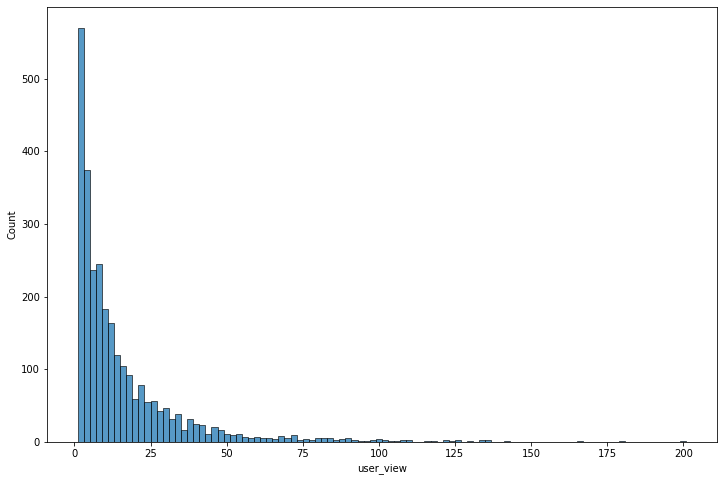

In [11]:
number_of_views = views_data.groupby('row_id')['user_view'].count()
fig = plt.figure(figsize=(12,8))
sns.histplot(data=views_data, x=number_of_views, bins=100)

In [12]:
mean_views = number_of_views.mean()
median_views = number_of_views.median()
std_views = number_of_views.std()
min_views = number_of_views.min()
max_views = number_of_views.max()
print(f'Mean views = {mean_views}\nMedian views = {median_views}\nStd views = {std_views}\nMin views = {min_views}\nMax views = {max_views}')

Mean views = 15.135357142857142
Median views = 8.0
Std views = 19.757042509042922
Min views = 1
Max views = 201


<AxesSubplot:xlabel='user_view'>

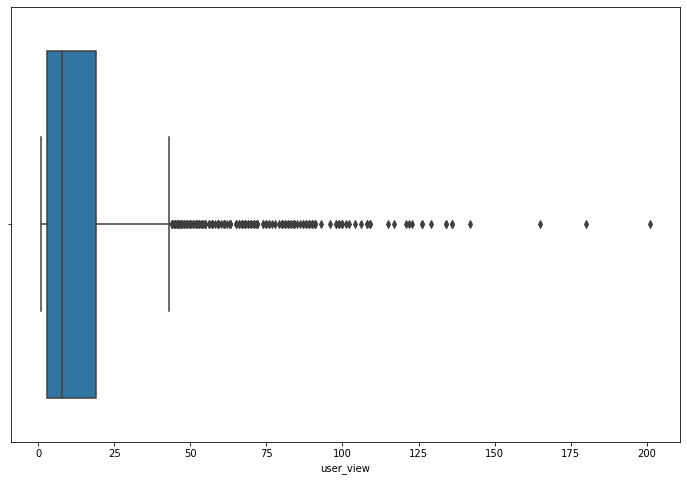

In [13]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=views_data, x=number_of_views)

In [14]:
# agrego una columna con los counts de user_view
views_data['view_count'] = views_data.groupby('row_id')['user_view'].transform('count')
views_data.head(2)

,row_id,item_bought,user_view,timestamps,bought_title,bought_domain_id,bought_price,bought_category_id,bought_condition,title,domain_id,price,category_id,condition,view_count
0,0,1748830,1786148,1571495142,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,0.0,Relógio Inteligente Smartwatch Gt08 Touch Scre...,MLB-SMARTWATCHES,119.99,MLB135384,0.0,18
1,0,1748830,1786148,1571495157,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,90.0,MLB135384,0.0,Relógio Inteligente Smartwatch Gt08 Touch Scre...,MLB-SMARTWATCHES,119.99,MLB135384,0.0,18


In [15]:
# Ahora voy a limpiar los outliers de user_view
def clean_outlier(dataset, column_name):
    interesting_col = dataset[column_name]
    mask_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (2.5 * interesting_col.std()))
    return dataset[mask_outlier]

Después de limpiar los outliers de los user_view count me quedo con el 97.1% de los datos usando 2.5-sigma


<AxesSubplot:xlabel='user_view'>

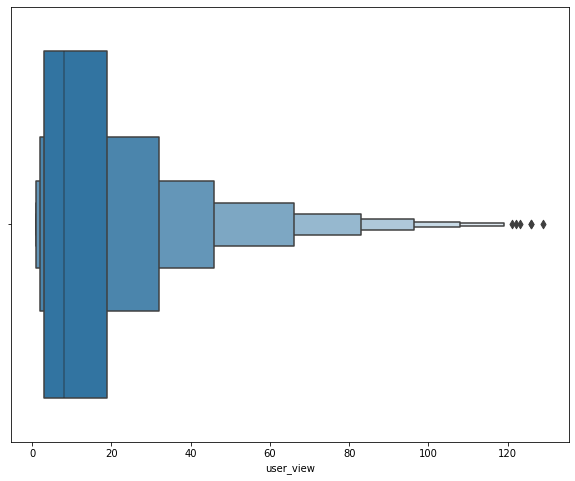

In [16]:
vdata = clean_outlier(views_data, 'view_count')
vrow, vcol = vdata.shape
viewsrow, viewscol = views_data.shape

print(f'Después de limpiar los outliers de los user_view count me quedo con el {np.round(vrow/viewsrow*100,2)}% de los datos usando 2.5-sigma')

item_view_clean = vdata.groupby('row_id')['user_view'].count()
fig = plt.figure(figsize=(10,8))
sns.boxenplot(data=vdata, x=item_view_clean)

Media = 14.738896848137536
Mediana = 8.0
Std = 18.296991114435688


<AxesSubplot:xlabel='user_view', ylabel='Count'>

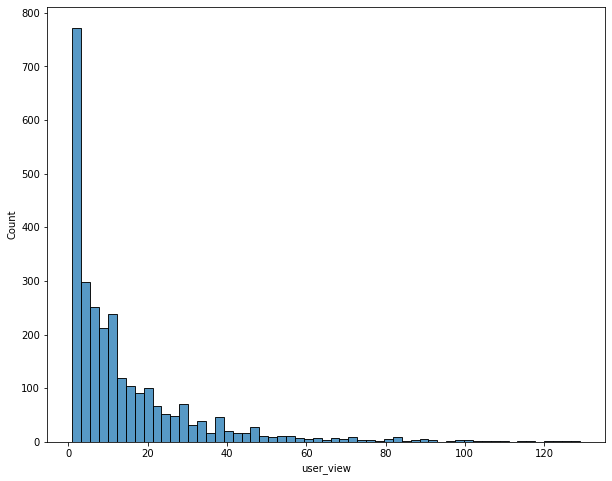

In [17]:
iview_mean = item_view_clean.mean()
iview_median = item_view_clean.median()
iview_std = item_view_clean.std()
print(f'Media = {iview_mean}\nMediana = {iview_median}\nStd = {iview_std}')
fig = plt.figure(figsize=(10,8))
sns.histplot(item_view_clean)

In [18]:
# veo como queda el views_data usando quantiles
number_of_views.quantile([.95, .98, .99, .995, .998])

0.950     53.000
0.980     82.000
0.990     98.010
0.995    117.020
0.998    134.804
Name: user_view, dtype: float64

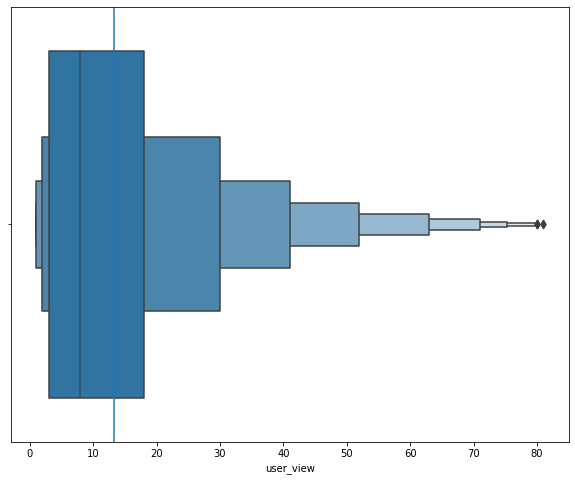

In [19]:
max_limit = number_of_views.quantile(.98)
vdata_q = vdata[vdata['view_count'] < max_limit]
num_views_q = vdata_q.groupby('row_id')['user_view'].count()
fig = plt.figure(figsize=(10,8))
sns.boxenplot(x=num_views_q)
plt.axvline(num_views_q.mean())

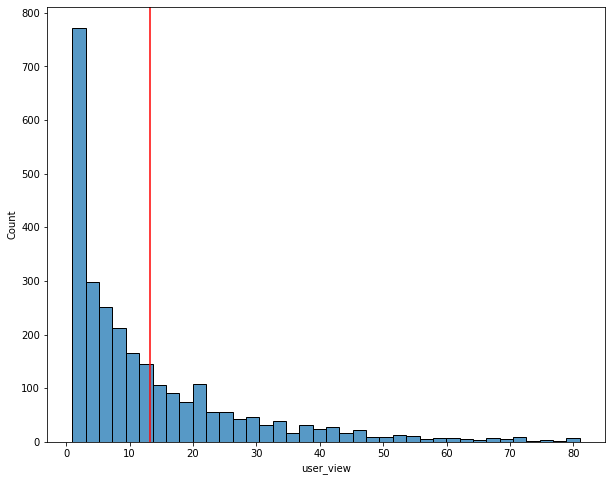

In [20]:
fig = plt.figure(figsize=(10,8))
sns.histplot(num_views_q)
plt.axvline(num_views_q.mean(), color='red')

In [21]:
# Con esta forma de limpiar los outliers veo las medias, mediana y std
numview_q_mean = num_views_q.mean()
numview_q_median = num_views_q.median()
numview_q_std = num_views_q.std()
print(f'Media = {numview_q_mean}\nMediana = {numview_q_median}\nStd = {numview_q_std}')

Media = 13.263215457528254
Mediana = 8.0
Std = 14.60553483658683


## ¿Que cantidad de ítems únicos conforman mi target?

In [22]:
# La mediana no cambió a pesar de que hice una limpieza de outliers, de todos modos trabajo con el dataset limpio por quantiles

unique_items = vdata_q['user_view'].nunique()
print(f'R: La cantidad de items únicos del target son = {unique_items}')

R: La cantidad de items únicos del target son = 19636


## ¿Cuántos ítems mira un usuario antes de realizar una compra?

In [23]:
print(f'R: La media de items vistos es = {np.round(numview_q_mean,2)}\n   Mientras que la mediana es = {numview_q_median}')

R: La media de items vistos es = 13.26
   Mientras que la mediana es = 8.0


In [24]:
#¿Cuántas búsquedas realiza un usuario antes de realizar una compra? 
# para responder esta pregunta, la única solución que se me ocurrió fue armar un nuevo dataset
# solo con las columnas row_id y user_search

test_search = pd.DataFrame()
test_search['user_search'] = train_data['user_search']
test_search = test_search.apply(pd.Series.explode)
test_search = test_search.dropna()
test_search = test_search.reset_index().rename({'index': 'row_id'}, axis=1)
test_search['search_count'] = test_search.groupby('row_id')['user_search'].transform('count')
test_search.head(2)

,row_id,user_search,search_count
0,0,RELOGIO SMARTWATCH,1
1,1,DESMAMADEIRA ELETRICA,5


<AxesSubplot:xlabel='user_search'>

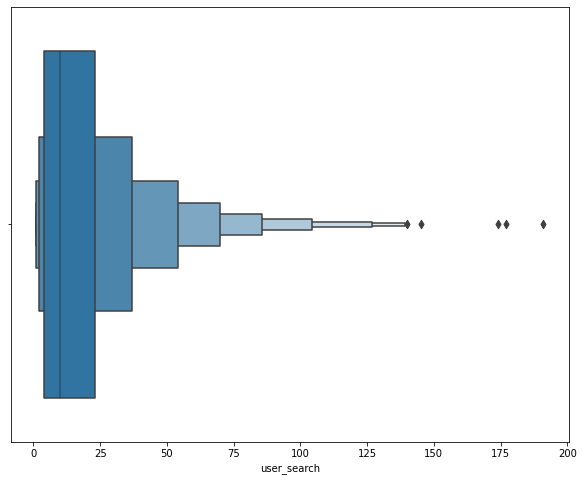

In [25]:
# miro un poco el dataset test_search para limpiar los outlier si los hubiera
number_of_search = test_search.groupby('row_id')['user_search'].count()
fig = plt.figure(figsize=(10,8))
sns.boxenplot(data=test_search, x=number_of_search)

In [26]:
# limpio por quantiles
number_of_search.quantile([.95, .98, .99, .995, .998])

0.950     59.000
0.980     82.000
0.990     98.000
0.995    115.690
0.998    139.076
Name: user_search, dtype: float64

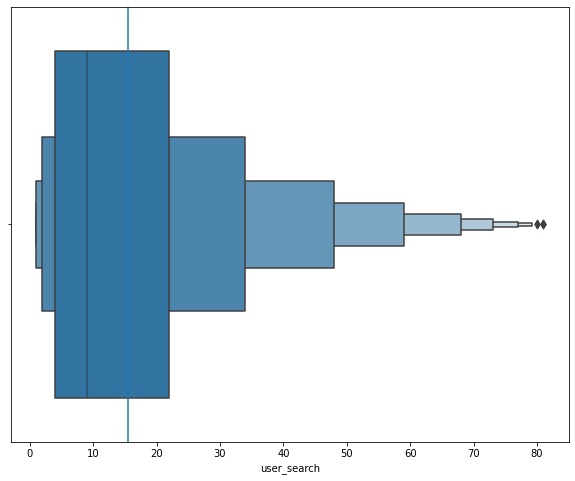

In [27]:
max_limit_search = number_of_search.quantile(.98)
search_q = test_search[test_search['search_count'] < max_limit_search]
num_search_q = search_q.groupby('row_id')['user_search'].count()
fig = plt.figure(figsize=(10,8))
sns.boxenplot(data=search_q, x=num_search_q)
plt.axvline(num_search_q.mean())

<AxesSubplot:xlabel='user_search', ylabel='Count'>

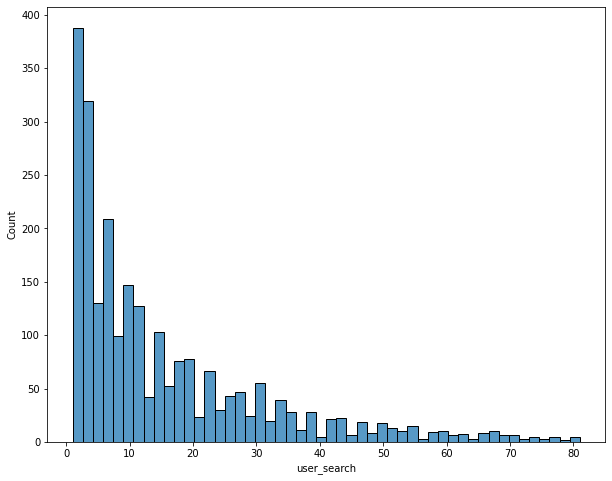

In [28]:
fig = plt.figure(figsize=(10,8))
sns.histplot(num_search_q, bins=50)

## ¿Cuántas búsquedas realiza un usuario antes de realizar una compra? 

In [29]:
search_mean = num_search_q.mean()
search_median = num_search_q.median()
search_std = num_search_q.std()
print(f'R: Media de búsquedas = {np.round(search_mean,2)}\n   Mediana de búsquedas = {np.round(search_median,2)}')

R: Media de búsquedas = 15.51
   Mediana de búsquedas = 9.0


## ¿Qué proporción de los ítems vistos corresponden a la categoría del ítem finalmente comprado? (dudas)

In [30]:
cat_unique = vdata.groupby('row_id')['category_id'].nunique()
bought_unique = vdata.groupby('row_id')['bought_category_id'].nunique()
prop = bought_unique/cat_unique
prop.mean()
# fig = plt.figure(figsize=(10,8))
# sns.barplot(y=prop)
# sns.barplot(y=cat_unique)


0.5440406903305318

## ¿Cuántas categorías recorre un usuario hasta comprar un item?

In [31]:
cat_unique.mean(),cat_unique.median()

(3.4258595988538683, 2.0)

## ¿Cómo se relacionan los precios de los ítems vistos con el ítem comprado?

In [39]:
price_unique = vdata_q.groupby('row_id')['price'].nunique()
bought_price_unique = vdata_q.groupby('row_id')['bought_price'].nunique()
prop_price = bought_price_unique/price_unique
prop_price.mean()

0.3669715900265662

## ¿Cuántas veces aparece el ítem comprado en nuestro historial de navegación?

In [52]:
# appear_count = vdata_q[vdata_q['user_view'] == vdata_q['item_bought']]
# a = appear_count.groupby('row_id')['item_bought'].count()
# a.sum(), appear_count.shape
match_appear_count = sum(vdata_q.user_view == vdata_q.item_bought)
unmatch_appear_count = sum(vdata_q.user_view != vdata_q.item_bought)
match_appear_count, unmatch_appear_count

(3534, 32847)